In [2]:
## Early Identification and Classification of Plant Disease Using CNN Models

In [3]:
!pip install torchsummary

In [39]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model


In [5]:
%matplotlib inline

In [ ]:
## RestNet 9 ##

In [6]:
data_dir = "../input/plantvillagecolor/color"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [7]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [8]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [9]:
# Unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of plants: 14
Unique Plants are: 
1. Tomato
2. Grape
3. Orange
4. Soybean
5. Squash
6. Potato
7. Corn_(maize)
8. Strawberry
9. Peach
10. Apple
11. Blueberry
12. Cherry_(including_sour)
13. Pepper,_bell
14. Raspberry


In [10]:
# number of unique diseases
print("Total number of diseases: {}".format(NumberOfDiseases))


Total number of diseases: 26


In [11]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1909
Tomato___healthy,1591
Grape___healthy,423
Orange___Haunglongbing_(Citrus_greening),5507
Soybean___healthy,5090
Squash___Powdery_mildew,1835
Potato___healthy,152
Corn_(maize)___Northern_Leaf_Blight,985
Tomato___Early_blight,1000
Tomato___Septoria_leaf_spot,1771


Text(0.5, 1.0, 'Images per each class of plant disease')

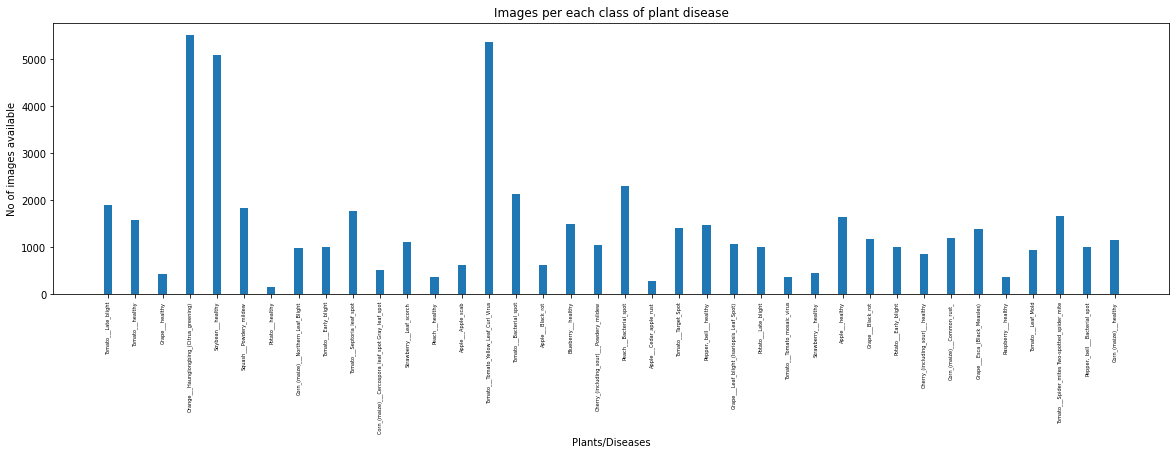

In [12]:
# plotting number of images available for each disease
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

In [13]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            # transforms.Resize(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.225, 0.225, 0.225])
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    # TODO: Split classes into equal sizes?!
    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [18]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [19]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 32


In [23]:
# TODO: Correct it

print(f"There are {len(train_dataset.dataset.imgs) + len(validation_dataset.dataset.imgs) + len(test_dataset.dataset.imgs)} images in total")

print(f"There are {len(train_dataset.dataset.imgs)} images for training")

print(f"There are {len(validation_dataset.dataset.imgs)} images for validation")

print(f"There are {len(test_dataset.dataset.imgs)} images for testing")

There are 162915 images in total
There are 54305 images for training
There are 54305 images for validation
There are 54305 images for testing


In [24]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

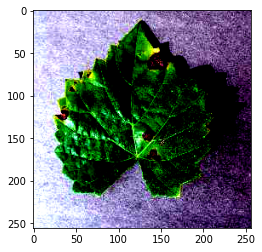

In [25]:
show_image(*train_dataset[21])